In [8]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from unidip import UniDip
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

from clusterless import preprocess
from clusterless import viz
from clusterless import decoder

In [2]:
pid = 'febb430e-2d50-4f83-87a0-b5ffbb9a4943'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_009/2020-02-27/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'

load neural data

In [3]:
sorted_trials, unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=True,
    triage=False
)

pid: febb430e-2d50-4f83-87a0-b5ffbb9a4943
eid: db4df448-e449-4a6f-a0e7-288711e7a75a
1st trial stim on time: 40.81, last trial stim on time 2252.10


In [4]:
n_trials = stim_on_times.shape[0]
n_channels = np1_channel_map.shape[0]

sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]
spike_clusters = sorted[:,1]

In [5]:
behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = preprocess.preprocess_static_behaviors(behave_dict)

choices left: 0.361, right: 0.639
stimuli left: 0.430, right: 0.570
reward wrong: 0.087, correct: 0.913


sorted decoding

In [6]:
sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

sorted neural data shape: (230, 465, 30)


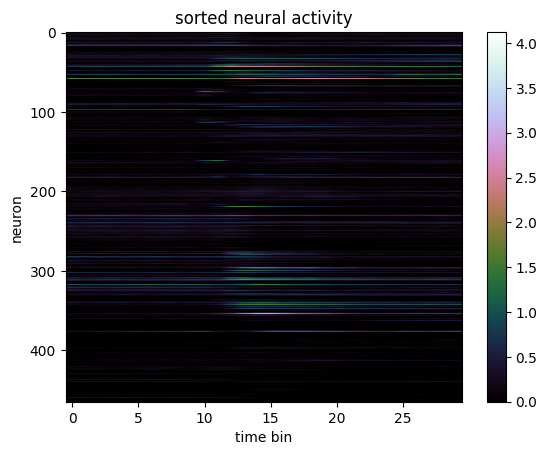

In [9]:
plt.imshow(sorted_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('sorted neural activity')
plt.xlabel('time bin')
plt.ylabel('neuron')
plt.colorbar();

In [10]:
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(sorted_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(sorted_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.957 auc: 1.000
choice fold 2 test accuracy: 1.000 auc: 1.000
choice fold 3 test accuracy: 1.000 auc: 1.000
choice fold 4 test accuracy: 0.957 auc: 0.990
choice fold 5 test accuracy: 0.913 auc: 0.984
choice mean of 5-fold cv accuracy: 0.965 auc: 0.995
choice sd of 5-fold cv accuracy: 0.033 auc: 0.007
stimulus fold 1 test accuracy: 0.413 auc: 0.818
stimulus fold 2 test accuracy: 0.543 auc: 0.884
stimulus fold 3 test accuracy: 0.587 auc: 0.850
stimulus fold 4 test accuracy: 0.457 auc: 0.846
stimulus fold 5 test accuracy: 0.587 auc: 0.903
stimulus mean of 5-fold cv accuracy: 0.517 auc: 0.860
stimulus sd of 5-fold cv accuracy: 0.071 auc: 0.030


thresholded decoding

In [11]:
thresholded_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

thresholded neural data shape: (230, 374, 30)


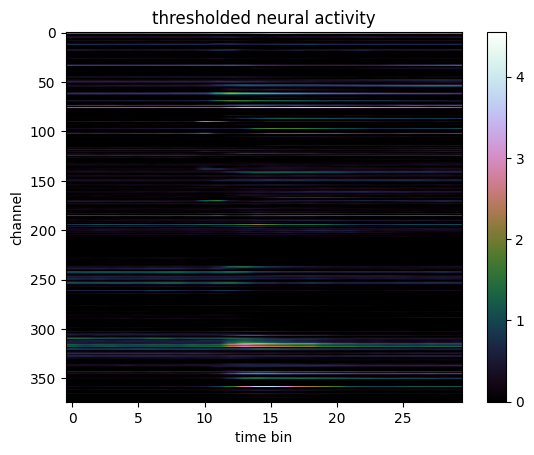

In [12]:
plt.imshow(thresholded_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('thresholded neural activity')
plt.xlabel('time bin')
plt.ylabel('channel')
plt.colorbar();

In [13]:
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(thresholded_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(thresholded_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.957 auc: 1.000
choice fold 2 test accuracy: 0.978 auc: 1.000
choice fold 3 test accuracy: 1.000 auc: 1.000
choice fold 4 test accuracy: 0.935 auc: 0.992
choice fold 5 test accuracy: 0.913 auc: 0.984
choice mean of 5-fold cv accuracy: 0.957 auc: 0.995
choice sd of 5-fold cv accuracy: 0.031 auc: 0.006
stimulus fold 1 test accuracy: 0.391 auc: 0.802
stimulus fold 2 test accuracy: 0.522 auc: 0.869
stimulus fold 3 test accuracy: 0.565 auc: 0.835
stimulus fold 4 test accuracy: 0.413 auc: 0.837
stimulus fold 5 test accuracy: 0.543 auc: 0.882
stimulus mean of 5-fold cv accuracy: 0.487 auc: 0.845
stimulus sd of 5-fold cv accuracy: 0.071 auc: 0.028


clusterless decoding

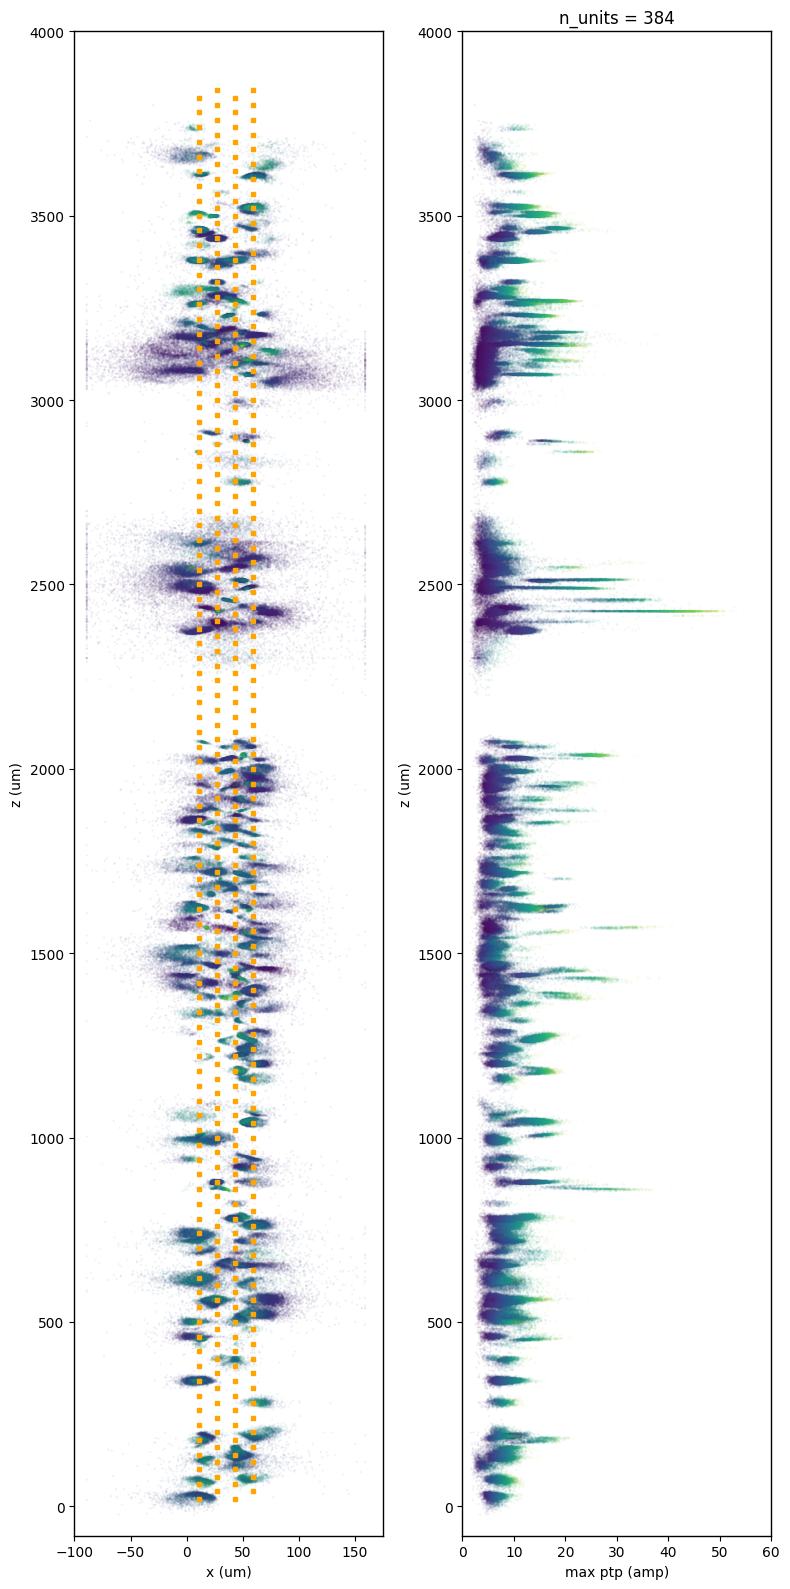

In [12]:
viz_tools.plot_MoG_bounds(
    data=spike_features, 
    labels=spike_channels, 
    labels_display=np.arange(n_channels), 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels),
)

model selection

In [14]:
sample_spikes = [trial[np.random.choice(len(trial), 300), 2:] for trial in unsorted_trials]
sample_spikes = np.vstack(sample_spikes)
print(sample_spikes.shape)

(69000, 3)


In [16]:
lowest_bic = np.infty
bic = []
k_range = range(300, 500, 50)

for k in k_range:
    print(f'--- fit MoG with {k} gaussians ---')
    gmm = GaussianMixture(
        init_params='kmeans',
        n_components=k, covariance_type='full',
        random_state=seed, warm_start=False, 
        verbose=1, 
        verbose_interval=5
    )
    gmm.fit(sample_spikes)
    bic.append(gmm.bic(sample_spikes))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_bic_gmm = gmm
    print(f'current bic: {round(bic[-1],2)}')
    print(f'best bic MoG has {len(best_bic_gmm.weights_)} gaussians.')

--- fit MoG with 300 gaussians ---
Initialization 0
  Iteration 5
  Iteration 10
  Iteration 15
  Iteration 20
  Iteration 25
Initialization converged: True
current bic: 1839011.95
best bic MoG has 300 gaussians.
--- fit MoG with 350 gaussians ---
Initialization 0
  Iteration 5
  Iteration 10
  Iteration 15
  Iteration 20
  Iteration 25
Initialization converged: True
current bic: 1839277.64
best bic MoG has 300 gaussians.
--- fit MoG with 400 gaussians ---
Initialization 0
  Iteration 5
  Iteration 10
  Iteration 15
  Iteration 20
  Iteration 25
  Iteration 30
Initialization converged: True
current bic: 1840215.79
best bic MoG has 300 gaussians.
--- fit MoG with 450 gaussians ---
Initialization 0
  Iteration 5
  Iteration 10
  Iteration 15
  Iteration 20
Initialization converged: True
current bic: 1844741.65
best bic MoG has 300 gaussians.


In [17]:
best_bic_gmm = GaussianMixture(
        init_params='kmeans',
        n_components=300, covariance_type='full',
        random_state=seed, warm_start=False, 
        verbose=1, 
        verbose_interval=1
    ).fit(spike_features)

Initialization 0
  Iteration 1
  Iteration 2
  Iteration 3
  Iteration 4
  Iteration 5
  Iteration 6
  Iteration 7
  Iteration 8
  Iteration 9
  Iteration 10
  Iteration 11
  Iteration 12
  Iteration 13
  Iteration 14
  Iteration 15
  Iteration 16
  Iteration 17
  Iteration 18
  Iteration 19
  Iteration 20
  Iteration 21
  Iteration 22
  Iteration 23
Initialization converged: True


In [18]:
spike_labels = []
spike_probs = []
offset = 100_000
for i in range(5):
    print(f'loading batch {i+1} ..')
    spike_labels.extend(best_bic_gmm.predict(spike_features[i*offset:(i+1)*offset]))
    spike_probs.extend(best_bic_gmm.predict_proba(spike_features[i*offset:(i+1)*offset]))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

loading batch 1 ..
loading batch 2 ..
loading batch 3 ..
loading batch 4 ..
loading batch 5 ..


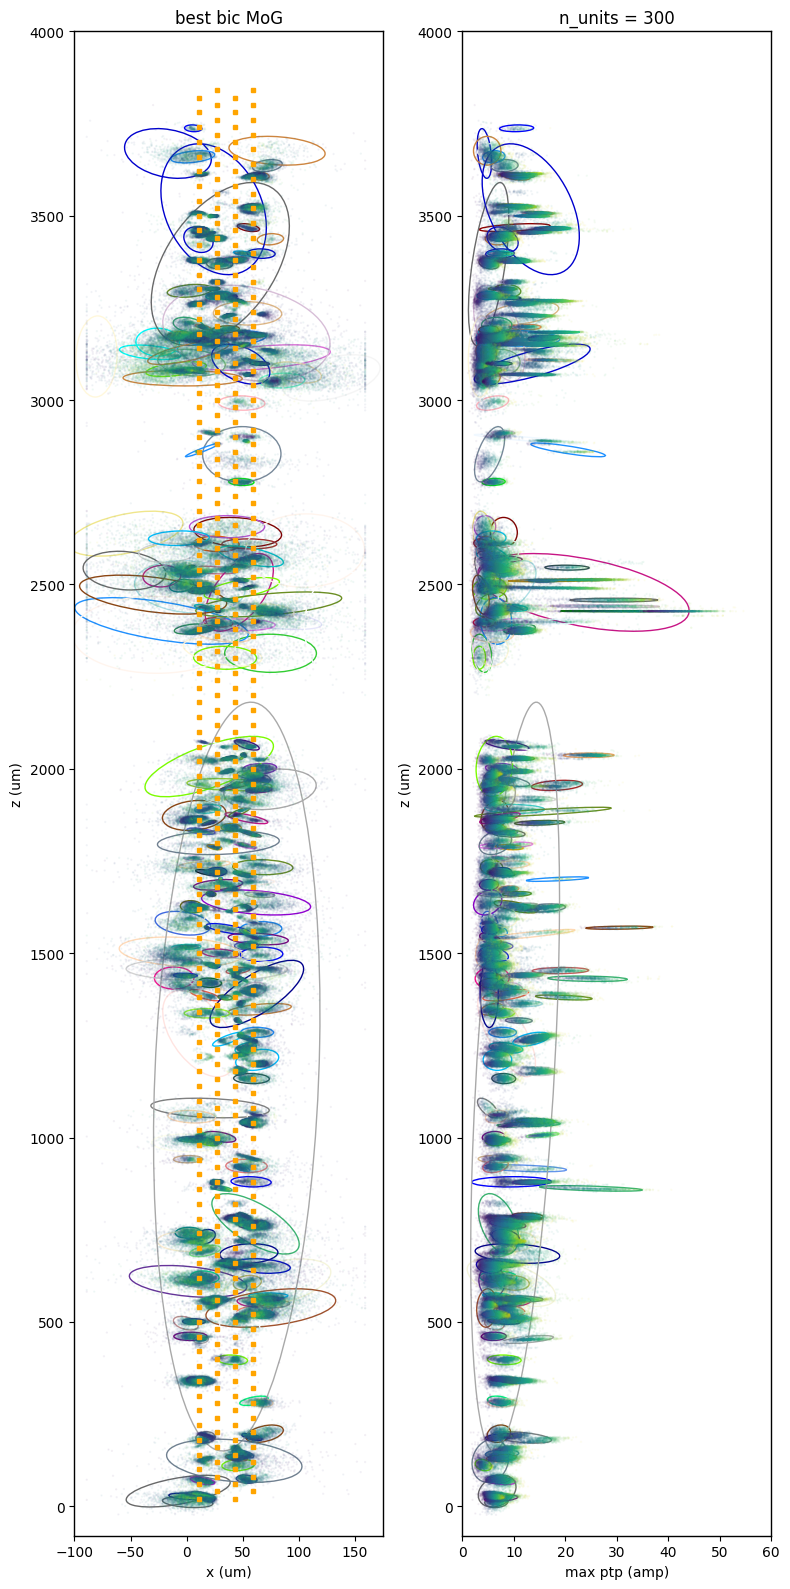

In [20]:
viz.plot_MoG_bounds(
    data=spike_features, 
    labels=spike_labels, 
    labels_display=np.unique(spike_labels), 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels),
    plot_MoG=True,
    title='best bic MoG'
)

In [21]:
clusterless_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

clusterless neural data shape: (230, 300, 30)


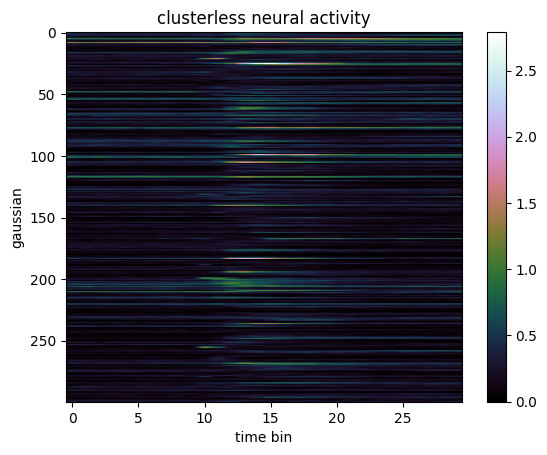

In [22]:
plt.imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('clusterless neural activity')
plt.xlabel('time bin')
plt.ylabel('gaussian')
plt.colorbar();

In [23]:
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.935 auc: 0.996
choice fold 2 test accuracy: 0.978 auc: 1.000
choice fold 3 test accuracy: 1.000 auc: 1.000
choice fold 4 test accuracy: 0.935 auc: 0.982
choice fold 5 test accuracy: 0.913 auc: 0.988
choice mean of 5-fold cv accuracy: 0.952 auc: 0.993
choice sd of 5-fold cv accuracy: 0.032 auc: 0.007


In [24]:
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

stimulus fold 1 test accuracy: 0.435 auc: 0.815
stimulus fold 2 test accuracy: 0.457 auc: 0.858
stimulus fold 3 test accuracy: 0.522 auc: 0.842
stimulus fold 4 test accuracy: 0.391 auc: 0.823
stimulus fold 5 test accuracy: 0.565 auc: 0.894
stimulus mean of 5-fold cv accuracy: 0.474 auc: 0.846
stimulus sd of 5-fold cv accuracy: 0.062 auc: 0.028


In [25]:
# gmm_name = f'../pretrained/danlab/Subjects/DY_009/kilosort_localizations/best_bic_gmm'
# np.save(gmm_name + '_weights', best_bic_gmm.weights_, allow_pickle=False)
# np.save(gmm_name + '_means', best_bic_gmm.means_, allow_pickle=False)
# np.save(gmm_name + '_covariances', best_bic_gmm.covariances_, allow_pickle=False)

distributed MoG using max channel (split-merge)

In [9]:
multi_modal_channels = {}
sub_weights_lst = []
sub_means_lst = []
sub_covs_lst = []
alpha = 0.1
for channel in np.unique(spike_channels):
    sub_spike_features = spike_features[spike_channels == channel]
    # a minimum of 2 points required for MoG
    if len(sub_spike_features) > 2: 
        pca = PCA(n_components=1, svd_solver='full')
        features_trans = pca.fit_transform(sub_spike_features).flatten()
        n_gaussians = len(UniDip(features_trans, alpha = alpha).run())
        if n_gaussians == 0:
            n_gaussians = 1
        if n_gaussians > 1:
            print(f'channel {channel} has {n_gaussians} modes ...')
            multi_modal_channels.update({channel: n_gaussians})
        if n_gaussians >= 1:
            sub_gmm = GaussianMixture(n_components=n_gaussians, 
                              max_iter=1000,
                              covariance_type='full',
                              init_params='kmeans', 
                              warm_start=False, 
                              verbose=0)
            sub_gmm.fit(sub_spike_features)
            sub_labels = sub_gmm.predict(sub_spike_features)
            sub_weights = [np.sum(sub_labels == i)/len(spike_features) for i in range(n_gaussians)]
            sub_weights_lst.append(sub_weights)
            sub_means_lst.append(sub_gmm.means_)
            sub_covs_lst.append(sub_gmm.covariances_)
sub_weights = np.hstack(sub_weights_lst)
sub_means = np.vstack(sub_means_lst)
sub_covs = np.vstack(sub_covs_lst)

channel 12.0 has 3 modes ...
channel 45.0 has 2 modes ...
channel 69.0 has 5 modes ...
channel 70.0 has 2 modes ...
channel 90.0 has 4 modes ...
channel 102.0 has 3 modes ...
channel 124.0 has 3 modes ...
channel 134.0 has 2 modes ...
channel 138.0 has 2 modes ...
channel 141.0 has 6 modes ...
channel 142.0 has 3 modes ...
channel 144.0 has 4 modes ...
channel 145.0 has 2 modes ...
channel 149.0 has 2 modes ...
channel 151.0 has 2 modes ...
channel 154.0 has 3 modes ...
channel 155.0 has 2 modes ...
channel 157.0 has 2 modes ...
channel 158.0 has 4 modes ...
channel 160.0 has 3 modes ...
channel 170.0 has 3 modes ...
channel 172.0 has 2 modes ...
channel 178.0 has 4 modes ...
channel 179.0 has 2 modes ...
channel 185.0 has 4 modes ...
channel 186.0 has 2 modes ...
channel 192.0 has 2 modes ...
channel 194.0 has 2 modes ...
channel 200.0 has 4 modes ...
channel 202.0 has 2 modes ...
channel 204.0 has 3 modes ...
channel 242.0 has 7 modes ...
channel 243.0 has 3 modes ...
channel 245.0 h

In [10]:
post_split_gmm = GaussianMixture(n_components=len(sub_weights), 
                                 covariance_type='full')
post_split_gmm.weights_ = sub_weights
post_split_gmm.means_ = sub_means
post_split_gmm.covariances_ = sub_covs
post_split_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(sub_covs))

In [11]:
spike_labels = []
spike_probs = []
offset = 100_000
for i in range(5):
    print(f'loading batch {i+1} ..')
    spike_labels.extend(post_split_gmm.predict(spike_features[i*offset:(i+1)*offset]))
    spike_probs.extend(post_split_gmm.predict_proba(spike_features[i*offset:(i+1)*offset]))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

loading batch 1 ..
loading batch 2 ..
loading batch 3 ..
loading batch 4 ..
loading batch 5 ..


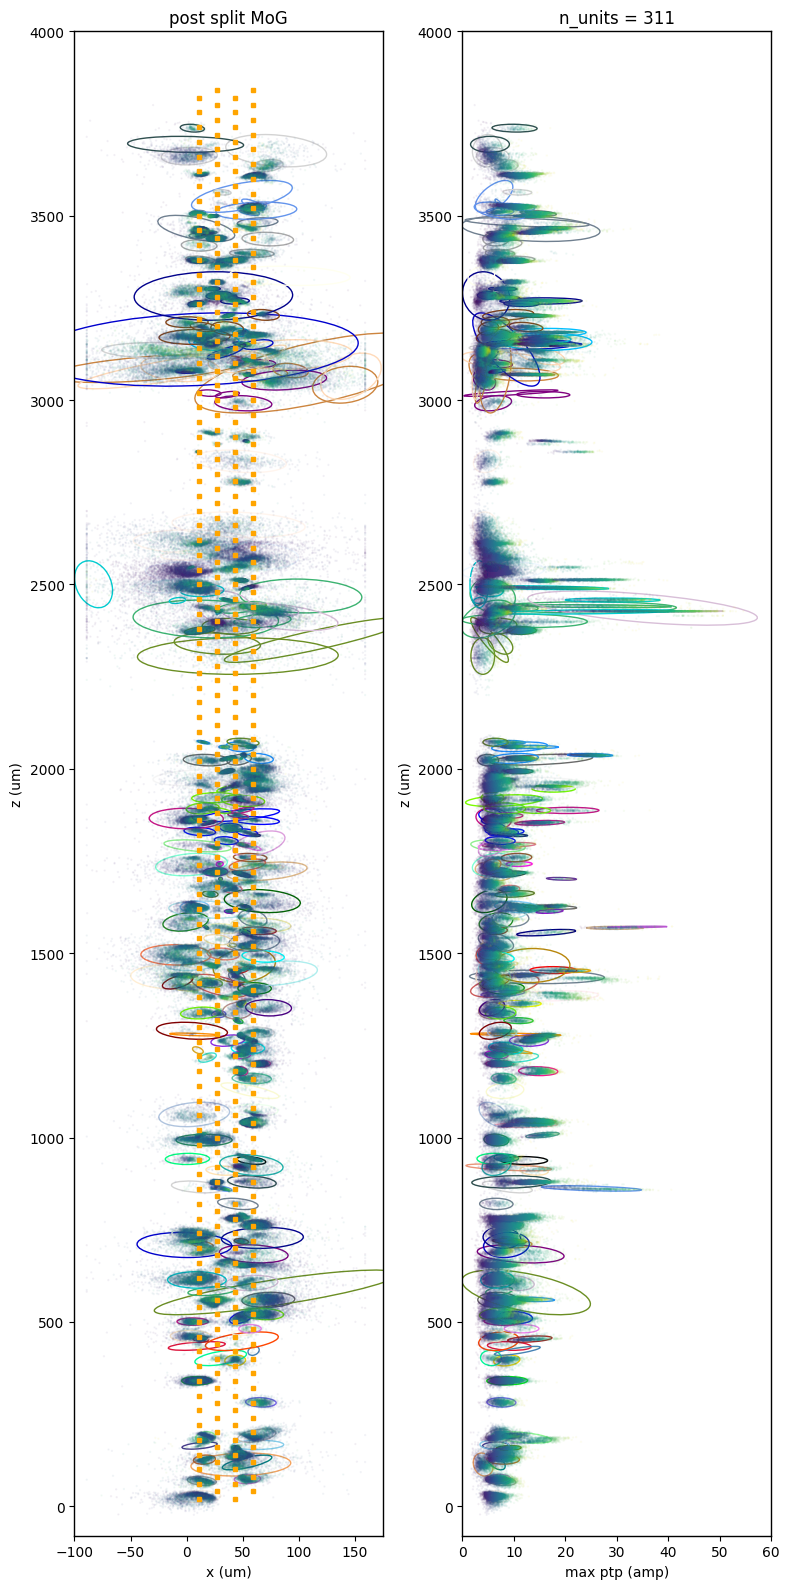

In [13]:
viz.plot_MoG_bounds(
    data=spike_features, 
    labels=spike_labels, 
    labels_display=np.unique(spike_labels), 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels),
    plot_MoG=True,
    title='post split MoG'
)

In [15]:
clusterless_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

clusterless neural data shape: (230, 311, 30)


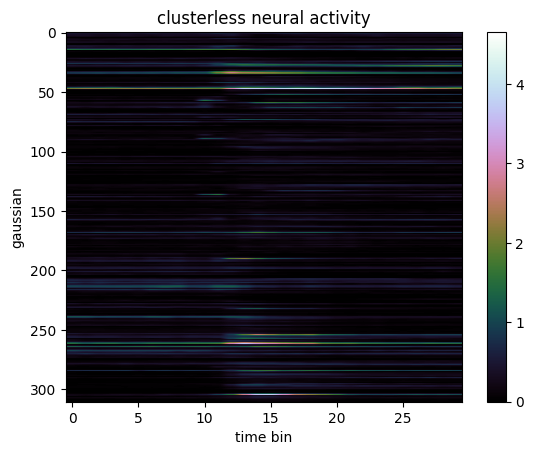

In [16]:
plt.imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('clusterless neural activity')
plt.xlabel('time bin')
plt.ylabel('gaussian')
plt.colorbar();

In [18]:
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.957 auc: 0.998
choice fold 2 test accuracy: 0.978 auc: 1.000
choice fold 3 test accuracy: 1.000 auc: 1.000
choice fold 4 test accuracy: 0.978 auc: 0.992
choice fold 5 test accuracy: 0.913 auc: 0.986
choice mean of 5-fold cv accuracy: 0.965 auc: 0.995
choice sd of 5-fold cv accuracy: 0.029 auc: 0.006
stimulus fold 1 test accuracy: 0.457 auc: 0.815
stimulus fold 2 test accuracy: 0.543 auc: 0.854
stimulus fold 3 test accuracy: 0.565 auc: 0.842
stimulus fold 4 test accuracy: 0.413 auc: 0.844
stimulus fold 5 test accuracy: 0.522 auc: 0.876
stimulus mean of 5-fold cv accuracy: 0.500 auc: 0.846
stimulus sd of 5-fold cv accuracy: 0.057 auc: 0.020


In [19]:
# gmm_name = f'../pretrained/danlab/Subjects/DY_009/kilosort_localizations/init_max_chan_gmm'
# np.save(gmm_name + '_weights', post_split_gmm.weights_, allow_pickle=False)
# np.save(gmm_name + '_means', post_split_gmm.means_, allow_pickle=False)
# np.save(gmm_name + '_covariances', post_split_gmm.covariances_, allow_pickle=False)

In [25]:
del post_split_gmm
del spike_labels
del spike_probs